# House price prediction, California

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import os
from d2l import torch as d2l
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 读入数据

In [2]:
train_path = './data/train.csv'
test_path = './data/test.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


## 一共是 39 维特征（去除第一列 id 和 label）

In [5]:
train_data.columns

Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Region', 'Elementary School',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School', 'Middle School Score', 'Middle School Distance',
       'High School', 'High School Score', 'High School Distance', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Tax assessed value',
       'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')

In [6]:
test_data.columns

Index(['Id', 'Address', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling',
       'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip', 'State'],
      dtype='object')

## 来看看数据

In [7]:
train_data.describe()

,Id,Sold Price,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Zip
count,47439.000000,4.743900e+04,46394.000000,3.325800e+04,43974.000000,39574.000000,4.491300e+04,46523.000000,46522.000000,42543.000000,42697.000000,30734.000000,30735.000000,42220.000000,42438.000000,4.378700e+04,43129.000000,4.743900e+04,2.967300e+04,47439.000000
mean,23719.000000,1.296050e+06,1956.634888,2.353383e+05,2.355642,2.094961,5.774587e+03,1.567117,1.491746,5.720824,1.152411,5.317206,1.691593,6.134344,2.410366,7.863118e+05,9956.843817,1.315890e+06,8.078537e+05,93279.178587
std,13694.604047,1.694452e+06,145.802456,1.192507e+07,1.188805,0.963320,8.324363e+05,9.011608,8.964319,2.103350,2.332367,2.002768,2.462879,1.984711,3.596120,1.157796e+06,13884.254976,2.628695e+06,1.177903e+06,2263.459104
min,0.000000,1.005000e+05,0.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,-15.000000,-15.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,85611.000000
25%,11859.500000,5.650000e+05,1946.000000,4.991000e+03,2.000000,2.000000,1.187000e+03,0.000000,0.000000,4.000000,0.300000,4.000000,0.600000,5.000000,0.800000,2.549615e+05,3467.000000,5.745000e+05,3.350000e+05,90220.000000
50%,23719.000000,9.600000e+05,1967.000000,6.502000e+03,2.000000,2.000000,1.566000e+03,1.000000,1.000000,6.000000,0.500000,5.000000,1.000000,6.000000,1.300000,5.475240e+05,7129.000000,9.490000e+05,5.980000e+05,94114.000000
75%,35578.500000,1.525000e+06,1989.000000,1.045400e+04,3.000000,2.000000,2.142000e+03,2.000000,2.000000,7.000000,1.000000,7.000000,1.800000,8.000000,2.400000,9.371625e+05,12010.000000,1.498844e+06,9.500000e+05,95073.000000
max,47438.000000,9.000000e+07,9999.000000,1.897474e+09,24.000000,17.000000,1.764164e+08,1000.000000,1000.000000,10.000000,57.200000,9.000000,57.200000,10.000000,73.900000,4.590000e+07,552485.000000,4.025320e+08,9.000000e+07,96155.000000


In [10]:
labels = [column for column in train_data.columns if column not in test_data.columns]
labels

['Sold Price']

In [13]:
features = [column for column in train_data.columns if column in test_data.columns and column not in ['Id']]
features

['Address',
 'Summary',
 'Type',
 'Year built',
 'Heating',
 'Cooling',
 'Parking',
 'Lot',
 'Bedrooms',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Region',
 'Elementary School',
 'Elementary School Score',
 'Elementary School Distance',
 'Middle School',
 'Middle School Score',
 'Middle School Distance',
 'High School',
 'High School Score',
 'High School Distance',
 'Flooring',
 'Heating features',
 'Cooling features',
 'Appliances included',
 'Laundry features',
 'Parking features',
 'Tax assessed value',
 'Annual tax amount',
 'Listed On',
 'Listed Price',
 'Last Sold On',
 'Last Sold Price',
 'City',
 'Zip',
 'State']

## 数据预处理

### 特征选择
由于训练样本中的特征很多，而且有些是文本类型的，不易处理，因此这里需要选择一些特征，不然后面内存可能会爆掉。

### 去除冗余数据

In [16]:
numeric_features = [column for column in features if train_data[column].dtype != 'object']
numeric_features

['Year built',
 'Lot',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Score',
 'Elementary School Distance',
 'Middle School Score',
 'Middle School Distance',
 'High School Score',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed Price',
 'Last Sold Price',
 'Zip']

#### 但是这里 Zip 应该不能简单当作数值型数据来处理，因为 Zip 其实也相当于是一个分类型数据

In [18]:
non_numeric_features = [column for column in features if column not in numeric_features]
non_numeric_features

['Address',
 'Summary',
 'Type',
 'Heating',
 'Cooling',
 'Parking',
 'Bedrooms',
 'Region',
 'Elementary School',
 'Middle School',
 'High School',
 'Flooring',
 'Heating features',
 'Cooling features',
 'Appliances included',
 'Laundry features',
 'Parking features',
 'Listed On',
 'Last Sold On',
 'City',
 'State']

### 第一次的时候遇到一个问题就是这里 get_dummies 直接内存爆炸了，我们先看一下每种有多少类

In [19]:
train_data[non_numeric_features].nunique()

Address                47325
Summary                46788
Type                     158
Heating                 1860
Cooling                  541
Parking                 5113
Bedrooms                 264
Region                   949
Elementary School       1717
Middle School            488
High School              630
Flooring                1348
Heating features        1122
Cooling features         312
Appliances included     4584
Laundry features        1976
Parking features        4960
Listed On               2467
Last Sold On            6113
City                     929
State                      2
dtype: int64

可以看到这里面 Address 和 Summary 每个人都不一样，如果用 onehot encoding 必然爆内存,现在也不知道怎么处理，因此就先去掉，还有 State，因为都是加州，而且更具体的地址信息可以由邮编来指出，因此也可以去掉

In [20]:
train_data['Listed On'].head()

0    2019-10-24
1    2019-10-16
2    2019-08-25
3    2019-10-24
4    2019-06-07
Name: Listed On, dtype: object

In [21]:
train_data['Last Sold On'].head()

0           NaN
1    2019-08-30
2           NaN
3    2016-08-30
4    2016-06-27
Name: Last Sold On, dtype: object

这两个是日期型数据

In [22]:
train_data['Bedrooms'].head()

0    Ground Floor Bedroom, Master Bedroom on Ground...
1                                                    3
2                                                    2
3                                                    5
4                                                  NaN
Name: Bedrooms, dtype: object

我就想着说 Bedrooms 怎么会不是数值数据，这里也需要处理一下

In [23]:
train_data['Zip'].nunique()

1245

#### 分析完上面的数据之后，我的策略是保留所有数值型，非数值型里面把目前的 Bedrooms 处理一下，保留 Type, Zip 也太多类了，还是扔掉算了

## 预处理之前先合并一下

In [25]:
features = numeric_features + ['Bedrooms', 'Type']
features = [column for column in features if column not in ['Zip']]
features

['Year built',
 'Lot',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Score',
 'Elementary School Distance',
 'Middle School Score',
 'Middle School Distance',
 'High School Score',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed Price',
 'Last Sold Price',
 'Bedrooms',
 'Type']

In [27]:
all_data = pd.concat((train_data[features], test_data[features]))
all_data.describe()

,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price
count,77123.000000,5.607600e+04,73655.000000,66137.000000,7.518700e+04,77398.000000,77398.000000,70330.000000,70572.000000,50786.000000,50788.000000,71281.000000,71890.000000,7.274200e+04,71856.000000,7.906500e+04,4.952000e+04
mean,1962.739572,3.690859e+05,2.391311,2.100292,4.216193e+03,1.861844,1.690767,5.710138,1.141035,5.249931,1.710690,6.160057,2.349060,6.855887e+05,8665.371883,1.138944e+06,6.966890e+05
std,129.066775,1.996199e+07,1.161958,0.942378,6.433812e+05,13.738636,13.676751,2.071209,2.184128,2.022063,2.321382,1.979861,3.297097,1.031404e+06,12823.211966,2.173946e+06,1.009869e+06
min,0.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,-15.000000,-15.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1950.000000,5.087000e+03,2.000000,2.000000,1.200000e+03,0.000000,0.000000,4.000000,0.300000,3.000000,0.700000,5.000000,0.800000,2.250730e+05,3024.000000,4.800000e+05,2.790000e+05
50%,1972.000000,6.753000e+03,2.000000,2.000000,1.586000e+03,2.000000,2.000000,6.000000,0.600000,5.000000,1.100000,6.000000,1.400000,4.535080e+05,5912.000000,7.950000e+05,4.950000e+05
75%,1992.000000,1.063200e+04,3.000000,2.000000,2.167000e+03,2.000000,2.000000,7.000000,1.000000,7.000000,1.900000,8.000000,2.400000,8.179620e+05,10451.000000,1.299000e+06,8.200000e+05
max,9999.000000,2.217378e+09,24.000000,24.000000,1.764164e+08,3109.000000,3109.000000,10.000000,57.200000,10.000000,57.200000,10.000000,73.900000,4.590000e+07,999999.000000,4.025320e+08,9.000000e+07


In [28]:
all_data.columns

Index(['Year built', 'Lot', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School Score', 'Middle School Distance', 'High School Score',
       'High School Distance', 'Tax assessed value', 'Annual tax amount',
       'Listed Price', 'Last Sold Price', 'Bedrooms', 'Type'],
      dtype='object')

In [29]:
all_data.dtypes

Year built                     float64
Lot                            float64
Bathrooms                      float64
Full bathrooms                 float64
Total interior livable area    float64
Total spaces                   float64
Garage spaces                  float64
Elementary School Score        float64
Elementary School Distance     float64
Middle School Score            float64
Middle School Distance         float64
High School Score              float64
High School Distance           float64
Tax assessed value             float64
Annual tax amount              float64
Listed Price                   float64
Last Sold Price                float64
Bedrooms                        object
Type                            object
dtype: object

#### 处理一下 Bedrooms

In [30]:
all_data['Bedrooms'] = pd.to_numeric(all_data['Bedrooms'], errors='coerce')
all_data['Bedrooms']

0        NaN
1        3.0
2        2.0
3        5.0
4        NaN
        ... 
31621    5.0
31622    2.0
31623    NaN
31624    3.0
31625    4.0
Name: Bedrooms, Length: 79065, dtype: float64

In [31]:
all_data.dtypes

Year built                     float64
Lot                            float64
Bathrooms                      float64
Full bathrooms                 float64
Total interior livable area    float64
Total spaces                   float64
Garage spaces                  float64
Elementary School Score        float64
Elementary School Distance     float64
Middle School Score            float64
Middle School Distance         float64
High School Score              float64
High School Distance           float64
Tax assessed value             float64
Annual tax amount              float64
Listed Price                   float64
Last Sold Price                float64
Bedrooms                       float64
Type                            object
dtype: object

In [32]:
numeric_features = [column for column in all_data.columns if all_data[column].dtype != 'object']
numeric_features

['Year built',
 'Lot',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Score',
 'Elementary School Distance',
 'Middle School Score',
 'Middle School Distance',
 'High School Score',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed Price',
 'Last Sold Price',
 'Bedrooms']

### 对数值很大的特征做对数操作，预防数值稳定性的问题

In [36]:
large_val_features = [column for column in numeric_features if all_data[column].mean() > 1000]
large_val_features

['Year built',
 'Lot',
 'Total interior livable area',
 'Tax assessed value',
 'Annual tax amount',
 'Listed Price',
 'Last Sold Price']

In [37]:
for f in large_val_features:
    all_data[f] = np.log(1+all_data[f])

In [38]:
all_data[large_val_features].describe()

,Year built,Lot,Total interior livable area,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price
count,77123.000000,56076.000000,75187.000000,72742.000000,71856.000000,79065.000000,49520.000000
mean,7.558527,8.994692,7.399292,12.941501,8.618245,13.572668,13.039366
std,0.456226,1.543520,0.497900,1.029662,0.960093,0.953491,0.969194
min,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000
25%,7.576097,8.534640,7.090910,12.324185,8.014666,13.081543,12.538971
50%,7.587311,8.817890,7.369601,13.024770,8.684909,13.586099,13.112315
75%,7.597396,9.271718,7.681560,13.614572,9.254549,14.077106,13.617061
max,9.210340,21.519591,18.988358,17.641976,13.815511,19.813285,18.315320


### 数值型数据归一化

In [40]:
all_data[numeric_features] = all_data[numeric_features].apply(lambda x:(x-x.mean())/x.std())

In [41]:
all_data.describe()

,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Bedrooms
count,7.712300e+04,5.607600e+04,7.365500e+04,6.613700e+04,7.518700e+04,7.739800e+04,7.739800e+04,7.033000e+04,7.057200e+04,5.078600e+04,5.078800e+04,7.128100e+04,7.189000e+04,7.274200e+04,7.185600e+04,7.906500e+04,4.952000e+04,6.639400e+04
mean,2.082436e-12,-2.763149e-14,-1.436180e-14,2.410896e-15,3.150520e-13,1.849120e-14,-5.168904e-15,1.841204e-14,2.700541e-16,-1.330250e-15,-1.630889e-15,-6.248362e-15,1.493850e-14,-4.857645e-14,-9.769432e-14,-1.570527e-13,-1.278824e-13,-3.928741e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.656752e+01,-5.827390e+00,-2.058002e+00,-1.167570e+00,-1.346885e+01,-1.227330e+00,-1.220375e+00,-2.274101e+00,-5.224212e-01,-2.101780e+00,-7.369272e-01,-2.606272e+00,-7.124630e-01,-1.256869e+01,-8.976470e+00,-1.423471e+01,-1.345383e+01,-2.492185e+00
25%,3.851141e-02,-2.980537e-01,-3.367686e-01,-1.064242e-01,-6.193659e-01,-1.355188e-01,-1.236235e-01,-8.256713e-01,-3.850666e-01,-1.112691e+00,-4.353827e-01,-5.859283e-01,-4.698253e-01,-5.995335e-01,-6.286669e-01,-5.150801e-01,-5.163005e-01,-8.610207e-01
50%,6.308952e-02,-1.145445e-01,-3.367686e-01,-1.064242e-01,-5.963374e-02,1.005602e-02,2.261011e-02,1.399482e-01,-2.477120e-01,-1.236020e-01,-2.630715e-01,-8.084238e-02,-2.878471e-01,8.087043e-02,6.943456e-02,1.408610e-02,7.526784e-02,-4.543842e-02
75%,8.519659e-02,1.794766e-01,5.238479e-01,-1.064242e-01,5.669164e-01,1.005602e-02,2.261011e-02,6.227580e-01,-6.457254e-02,8.654868e-01,8.155076e-02,9.293295e-01,1.545005e-02,6.536818e-01,6.627522e-01,5.290437e-01,5.960571e-01,7.701438e-01
max,3.620604e+00,8.114505e+00,1.859679e+01,2.323878e+01,2.327587e+01,2.261606e+02,2.271964e+02,2.071187e+00,2.566652e+01,2.349120e+00,2.390357e+01,1.939501e+00,2.170119e+01,4.565067e+00,5.413295e+00,6.545020e+00,5.443652e+00,3.176227e+01


In [42]:
all_data[numeric_features] = all_data[numeric_features].fillna(0)

In [43]:
all_data.describe()

,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Bedrooms
count,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04,7.906500e+04
mean,2.031287e-12,-1.959733e-14,-1.337910e-14,2.016688e-15,2.995992e-13,1.810134e-14,-5.059923e-15,1.637790e-14,2.410454e-16,-8.544624e-16,-1.047614e-15,-5.633207e-15,1.358286e-14,-4.469169e-14,-8.878673e-14,-1.570527e-13,-8.009534e-14,-3.299119e-14
std,9.876425e-01,8.421612e-01,9.651810e-01,9.145966e-01,9.751672e-01,9.894017e-01,9.894017e-01,9.431436e-01,9.447649e-01,8.014535e-01,8.014693e-01,9.494989e-01,9.535464e-01,9.591803e-01,9.533209e-01,1.000000e+00,7.914009e-01,9.163719e-01
min,-1.656752e+01,-5.827390e+00,-2.058002e+00,-1.167570e+00,-1.346885e+01,-1.227330e+00,-1.220375e+00,-2.274101e+00,-5.224212e-01,-2.101780e+00,-7.369272e-01,-2.606272e+00,-7.124630e-01,-1.256869e+01,-8.976470e+00,-1.423471e+01,-1.345383e+01,-2.492185e+00
25%,3.738765e-02,-2.013570e-01,-3.367686e-01,-1.064242e-01,-5.861953e-01,-1.355188e-01,-1.236235e-01,-8.256713e-01,-3.850666e-01,-1.236020e-01,-3.492271e-01,-5.859283e-01,-4.394956e-01,-5.229251e-01,-5.459595e-01,-5.150801e-01,-1.445981e-01,-4.543842e-02
50%,6.197829e-02,0.000000e+00,-3.367686e-01,-1.064242e-01,-3.476300e-03,1.005602e-02,2.261011e-02,0.000000e+00,-2.477120e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.575174e-01,0.000000e+00,0.000000e+00,1.408610e-02,0.000000e+00,-4.543842e-02
75%,8.409651e-02,1.719700e-02,5.238479e-01,0.000000e+00,5.266809e-01,1.005602e-02,2.261011e-02,6.227580e-01,0.000000e+00,3.709424e-01,0.000000e+00,4.242436e-01,0.000000e+00,6.027083e-01,5.984236e-01,5.290437e-01,2.771875e-01,0.000000e+00
max,3.620604e+00,8.114505e+00,1.859679e+01,2.323878e+01,2.327587e+01,2.261606e+02,2.271964e+02,2.071187e+00,2.566652e+01,2.349120e+00,2.390357e+01,1.939501e+00,2.170119e+01,4.565067e+00,5.413295e+00,6.545020e+00,5.443652e+00,3.176227e+01


In [44]:
all_data = pd.get_dummies(all_data, dummy_na=True)

In [45]:
all_data.shape

(79065, 193)

## 训练

In [46]:
from torch.utils import data
from torch.nn import functional as F

### 定义 MLP

In [55]:
class MLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features, in_features//2)
        self.layer2 = nn.Linear(in_features//2, in_features//4)
        self.layer3 = nn.Linear(in_features//4, in_features//8)
        self.layer4 = nn.Linear(in_features//8, in_features//16)
        self.layer5 = nn.Linear(in_features//16, in_features//32)
        self.out = nn.Linear(in_features//32, 1)
    def forward(self, X):
        X = F.relu(self.layer1(X))
        X = F.relu(self.layer2(X))
        X = F.relu(self.layer3(X))
        X = F.relu(self.layer4(X))
        X = F.relu(self.layer5(X))
        X = self.out(X)
        return X

In [56]:
loss = nn.MSELoss()

In [63]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [57]:
train_nums = train_data.shape[0]
train_features = all_data.iloc[:train_nums,:]
train_labels = train_data[labels]

In [58]:
train_features = torch.tensor(train_features.values, dtype=torch.float)
print(train_features.shape)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1), dtype=torch.float)
print(train_labels.shape)

torch.Size([47439, 193])
torch.Size([47439, 1])


In [59]:
test_features = all_data.iloc[train_nums:,:]
test_features = torch.tensor(test_features.values, dtype=torch.float)
print(test_features.shape)

torch.Size([31626, 193])


## 开炼！

In [60]:
in_features = all_data.shape[1]
net = MLP(in_features)

In [64]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []   # train_loss和test_loss
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法，对初始学习率没有那么敏感
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K 折交叉验证

In [65]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [68]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择

fold 1, train log rmse 0.381531, valid log rmse 0.397441
fold 2, train log rmse 0.322707, valid log rmse 0.318372
fold 3, train log rmse 0.278007, valid log rmse 0.286744
fold 4, train log rmse 0.358251, valid log rmse 0.380302
fold 5, train log rmse 0.303204, valid log rmse 0.333516
5-折验证: 平均训练log rmse: 0.328740, 平均验证log rmse: 0.343275


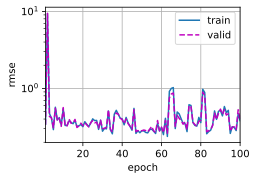

In [69]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 0.1, 64    # 调参数
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 预测和提交

In [70]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.326499


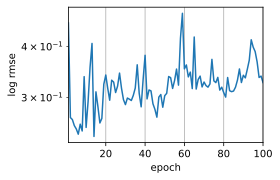

In [71]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

## Done